# Spatial Analysis
This notebook brings in the primary dataset we created in several other notebooks. This includes vaccination rates, vaccine distribution center walkshed coverage, COVID-19 cases, and demographic information for each zip code. 

We conduct a variety of spatial analyses to dive further into the data we assembled. This notebook is far from refined -- we test everything and some things work and others don't. For our final project, we will refine the statistical models, figure out what the tests are telling us, and figure out how the results contribute to the story we are telling.

# Initialize

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx

# autocorrelation
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# spatial regression
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import megadataframe
gdf = gpd.read_file('data/gdf.geojson')

In [4]:
# rename columns
gdf.columns = ('zcta',
 'neighborhood',
 'borough',
 'cases_100k',
 'deaths_100k',
 '%_fully',
 '%_partial',
 'population',
 '%_iso',
 '%_nonhisp',
 '%_hispanic',
 '%_white',
 '%_black',
 '%_native',
 '%_asian',
 '%_nhpi',
 '%_other',
 '%_multirace',
 '%_disability',
 '%_over65',
 '%_poverty',
 '%_foreign',
 '%_lessHS',
 '%_bachelorsbeyond',
 'geometry')

# High/Low Quartile Analysis

We will create quartiles for our primary variables of interest: percent of vaccine distribution walkshed coverage, percent of population vaccinated, COVID-19 case rate.

In [6]:
# create quartiles 

# walkshed coverage
gdf['irank'] = pd.qcut(gdf['%_iso'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
# vaccination rate
gdf['vrank'] = pd.qcut(gdf['%_partial'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
# covid case rate
gdf['crank'] = pd.qcut(gdf['cases_100k'], 4, labels=["Q1", "Q2", "Q3", "Q4"])


Here we will define a function that assigns "high/low" based on the quartiles for two variables. The inputs are a dataframe containing the quartiles (as created in the previous step), the name of the quartile column, and the name of the each variable to be displayed on the map. This will identify which zip codes have high/low rates of the first variable and high/low rates of the second variable. This will help us identify spatial mismatches between variables. 

In [95]:
# Walkshed Coverage and Partial Vaccination High/Low
def high_low(gdf, var1, var2, name1, name2):
    if gdf[var1] == 'Q4' and gdf[var2] == 'Q4':
        return 'High ' +  name1 + ', High ' + name2
    else:
        if gdf[var1] == 'Q1' and gdf[var2] == 'Q1':
            return 'Low ' +  name1 + ', Low ' + name2
        else:
            if gdf[var1] == 'Q4' and gdf[var2] == 'Q1':
                return 'High ' +  name1 + ', Low ' + name2
            else: 
                if gdf[var1] == 'Q1' and gdf[var2] == 'Q4':
                    return 'Low ' +  name1 + ', High ' + name2

In [96]:
# run function to create the high/low column
gdf['quartile_iso_vac'] = gdf.apply(high_low, args = ('irank', 'vrank', 'Walkshed', 'Vaccination'), axis=1)
gdf['quartile_vac_cases'] = gdf.apply(high_low, args = ('crank', 'vrank', 'COVID Cases', 'Vaccination'), axis=1)
gdf['quartile_iso_cases'] = gdf.apply(high_low, args = ('irank', 'crank', 'Walkshed', 'COVID Cases'), axis=1)

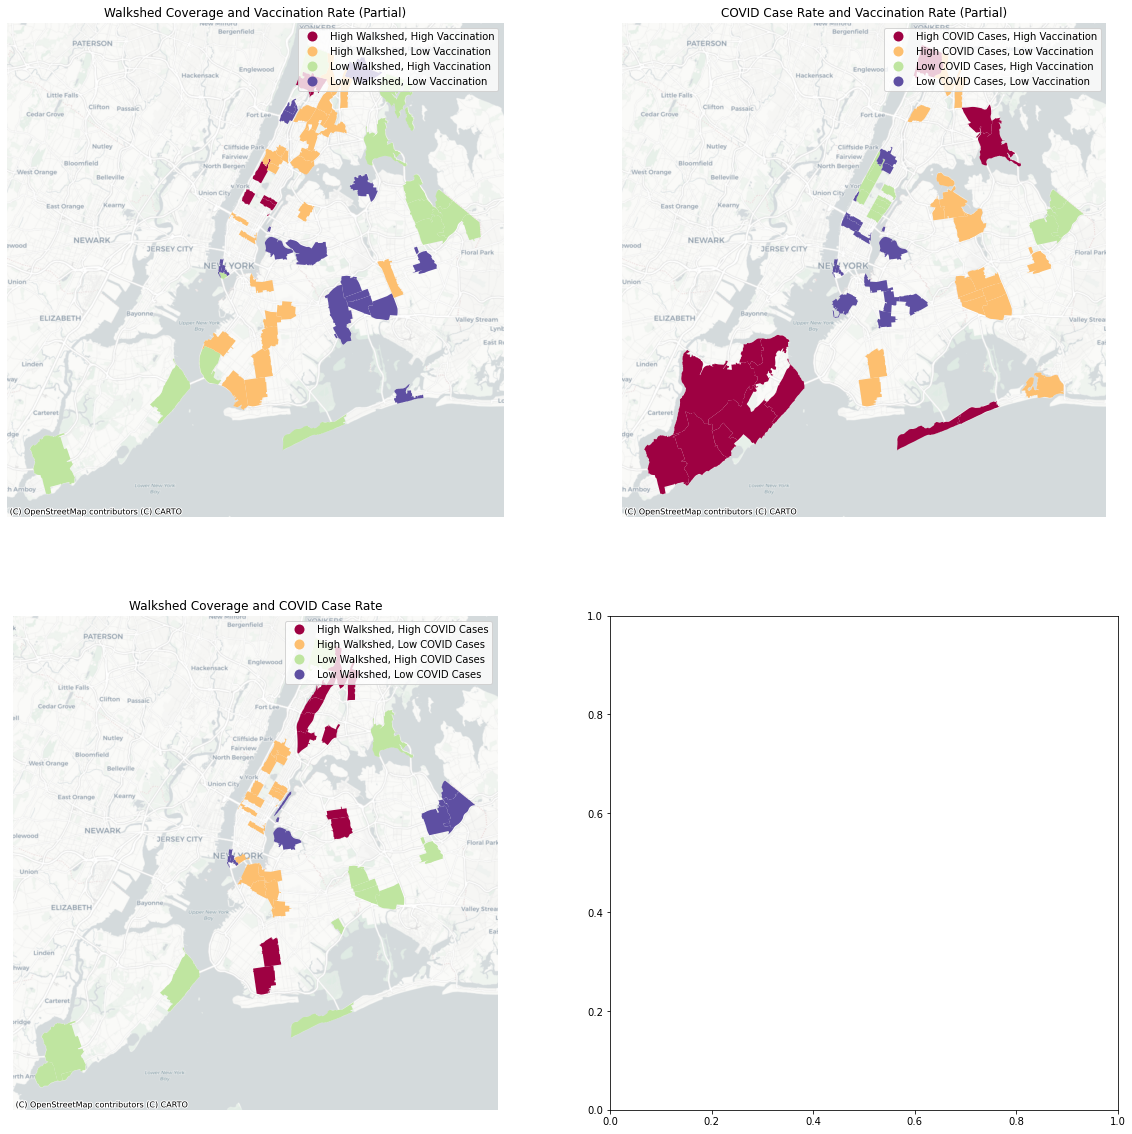

In [10]:
# High/Low Map
fig, ax = plt.subplots(2, 2, figsize=(20,20))

gdf.plot(ax=ax[0,0],
         column= 'quartile_iso_vac',
               legend=True,
              cmap=plt.get_cmap('Spectral'))

gdf.plot(ax=ax[0,1],
         column= 'quartile_vac_cases',
               legend=True,
              cmap=plt.get_cmap('Spectral'))

gdf.plot(ax=ax[1,0],
         column= 'quartile_iso_cases',
               legend=True,
              cmap=plt.get_cmap('Spectral'))

ax[0,0].set_title("Walkshed Coverage and Vaccination Rate (Partial)")
ax[0,1].set_title("COVID Case Rate and Vaccination Rate (Partial)")
ax[1,0].set_title("Walkshed Coverage and COVID Case Rate")


ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')

ctx.add_basemap(ax=ax[0,0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax=ax[0,1],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax=ax[1,0],source=ctx.providers.CartoDB.Positron)

Next, we will look at the demographics of each "high/low" category to identify explanatory variables in the spatial mismatch. We will look at the median value for each demographic variable.

In [100]:
column_means = ['%_hispanic', '%_white', '%_black', '%_asian', '%_disability', 
    '%_over65', '%_poverty', '%_foreign', '%_lessHS','%_bachelorsbeyond']
median_quart_isovac= gdf.groupby('quartile_iso_vac', as_index=False)[column_means].median()
median_quart_isovac

,quartile_iso_vac,%_hispanic,%_white,%_black,%_asian,%_disability,%_over65,%_poverty,%_foreign,%_lessHS,%_bachelorsbeyond
0,"High Walkshed, High Vaccination",15.598598,71.296962,4.504245,8.541102,12.902400,22.585184,7.956390,26.007306,2.491602,76.794052
1,"High Walkshed, Low Vaccination",25.213526,13.426693,26.885533,4.375623,12.878394,11.256028,25.179294,37.893484,21.389128,30.598448
2,"Low Walkshed, High Vaccination",12.154526,51.289414,2.986375,21.915509,12.873368,20.189129,7.131529,31.090538,8.985881,46.520383
3,"Low Walkshed, Low Vaccination",24.233974,22.845402,3.544384,17.007067,9.749948,12.222372,10.273197,42.511879,19.048965,28.810996


In [101]:
median_quart_vaccases= gdf.groupby('quartile_vac_cases', as_index=False)[column_means].median()
median_quart_vaccases

,quartile_vac_cases,%_hispanic,%_white,%_black,%_asian,%_disability,%_over65,%_poverty,%_foreign,%_lessHS,%_bachelorsbeyond
0,"High COVID Cases, High Vaccination",15.592925,62.434293,5.787190,5.321540,13.058444,17.455520,9.250713,22.005173,10.368858,35.583800
1,"High COVID Cases, Low Vaccination",38.214060,12.552348,13.233059,22.663078,11.759229,12.470866,15.034348,49.649705,23.190286,21.500473
2,"Low COVID Cases, High Vaccination",10.944820,71.296962,2.965709,10.461937,11.471251,22.209696,6.034957,23.525229,2.968293,78.545918
3,"Low COVID Cases, Low Vaccination",11.362679,58.744785,5.738691,16.041397,9.394753,10.439457,13.058315,26.095682,8.622164,68.250052


In [102]:
median_quart_isocases= gdf.groupby('quartile_iso_cases', as_index=False)[column_means].median()
median_quart_isocases

,quartile_iso_cases,%_hispanic,%_white,%_black,%_asian,%_disability,%_over65,%_poverty,%_foreign,%_lessHS,%_bachelorsbeyond
0,"High Walkshed, High COVID Cases",59.077974,4.747714,20.952977,3.963918,14.136131,11.977537,27.473105,42.643045,28.144001,19.501139
1,"High Walkshed, Low COVID Cases",13.652759,52.635463,9.317949,9.511000,10.985969,13.510000,13.026759,23.853075,8.739030,69.297855
2,"Low Walkshed, High COVID Cases",21.293886,30.774638,6.549601,9.941069,13.267526,15.265287,10.562542,32.507793,15.604358,28.727776
3,"Low Walkshed, Low COVID Cases",11.098545,61.733917,2.711223,25.118521,7.004759,10.245202,6.498939,31.652531,3.597633,71.176592


[Text(0, 0, 'High Walkshed, High COVID Cases'),
 Text(0, 0, 'High Walkshed, Low COVID Cases'),
 Text(0, 0, 'Low Walkshed, High COVID Cases'),
 Text(0, 0, 'Low Walkshed, Low COVID Cases')]

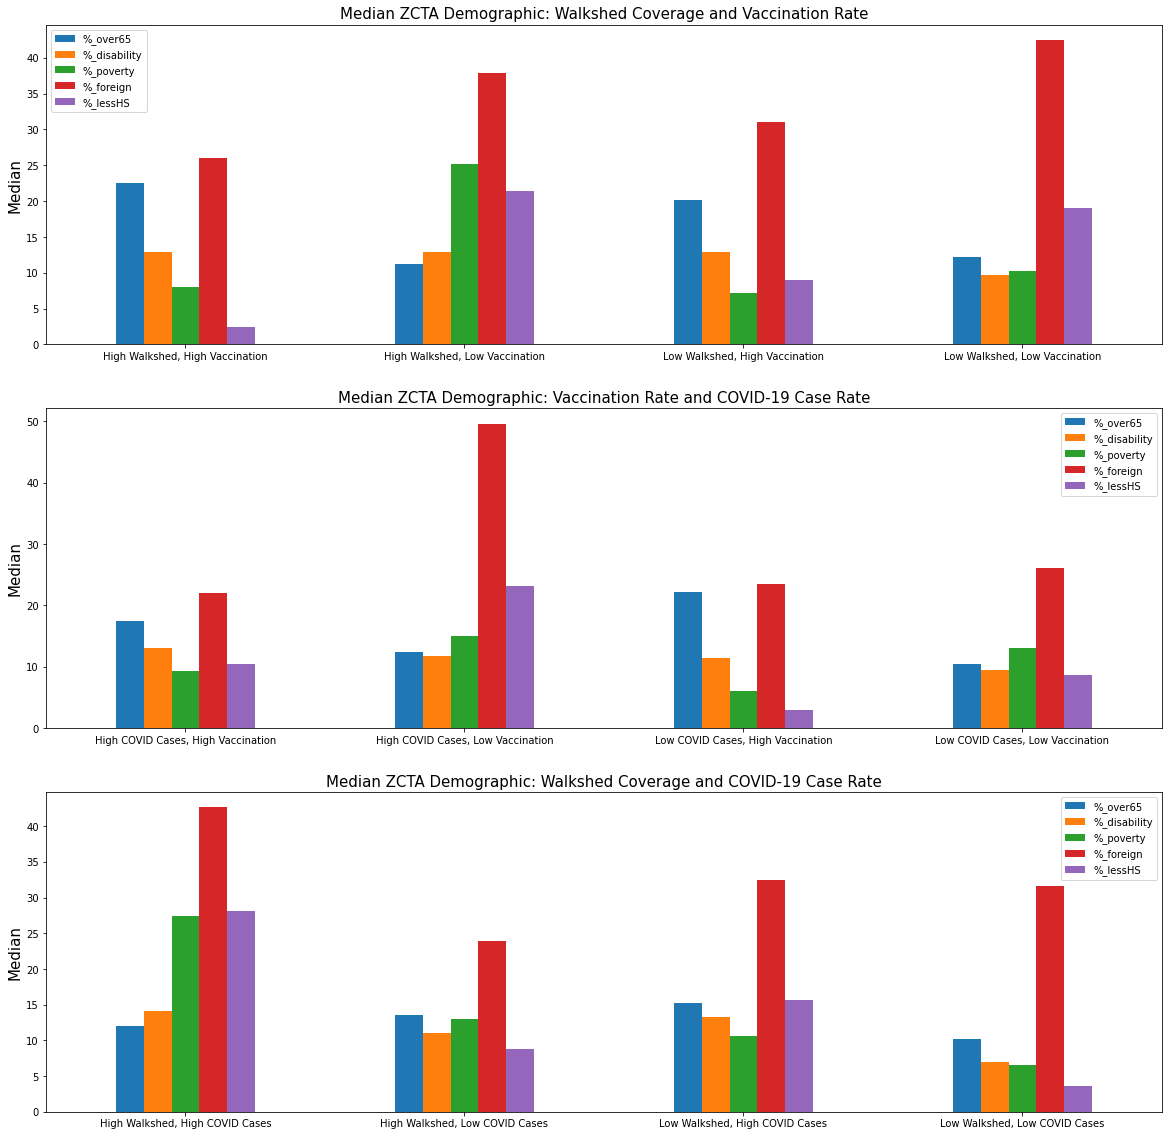

In [103]:
fig, axs = plt.subplots(3,1, figsize=(20,20))

ax1, ax2, ax3 = axs
                        
median_quart_isovac.reset_index().plot( ax=ax1, 
    x="quartile_iso_vac", y=["%_over65", "%_disability", '%_poverty', '%_foreign', '%_lessHS'], kind="bar")
ax1.set_title("Median ZCTA Demographic: Walkshed Coverage and Vaccination Rate", fontsize=15)
ax1.set_ylabel("Median", fontsize=15)
ax1.set_xlabel("", fontsize=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

                        
median_quart_vaccases.reset_index().plot( ax=ax2, 
    x="quartile_vac_cases", y=["%_over65", "%_disability", '%_poverty', '%_foreign', '%_lessHS'], kind="bar")
ax2.set_title("Median ZCTA Demographic: Vaccination Rate and COVID-19 Case Rate", fontsize=15)
ax2.set_ylabel("Median", fontsize=15)
ax2.set_xlabel("", fontsize=15)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

                        
median_quart_isocases.reset_index().plot(ax=ax3, 
    x="quartile_iso_cases", y=["%_over65", "%_disability", '%_poverty', '%_foreign', '%_lessHS'], kind="bar")
ax3.set_title("Median ZCTA Demographic: Walkshed Coverage and COVID-19 Case Rate", fontsize=15)
ax3.set_ylabel("Median", fontsize=15)
ax3.set_xlabel("", fontsize=15)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)


[Text(0, 0, 'High Walkshed, High COVID Cases'),
 Text(0, 0, 'High Walkshed, Low COVID Cases'),
 Text(0, 0, 'Low Walkshed, High COVID Cases'),
 Text(0, 0, 'Low Walkshed, Low COVID Cases')]

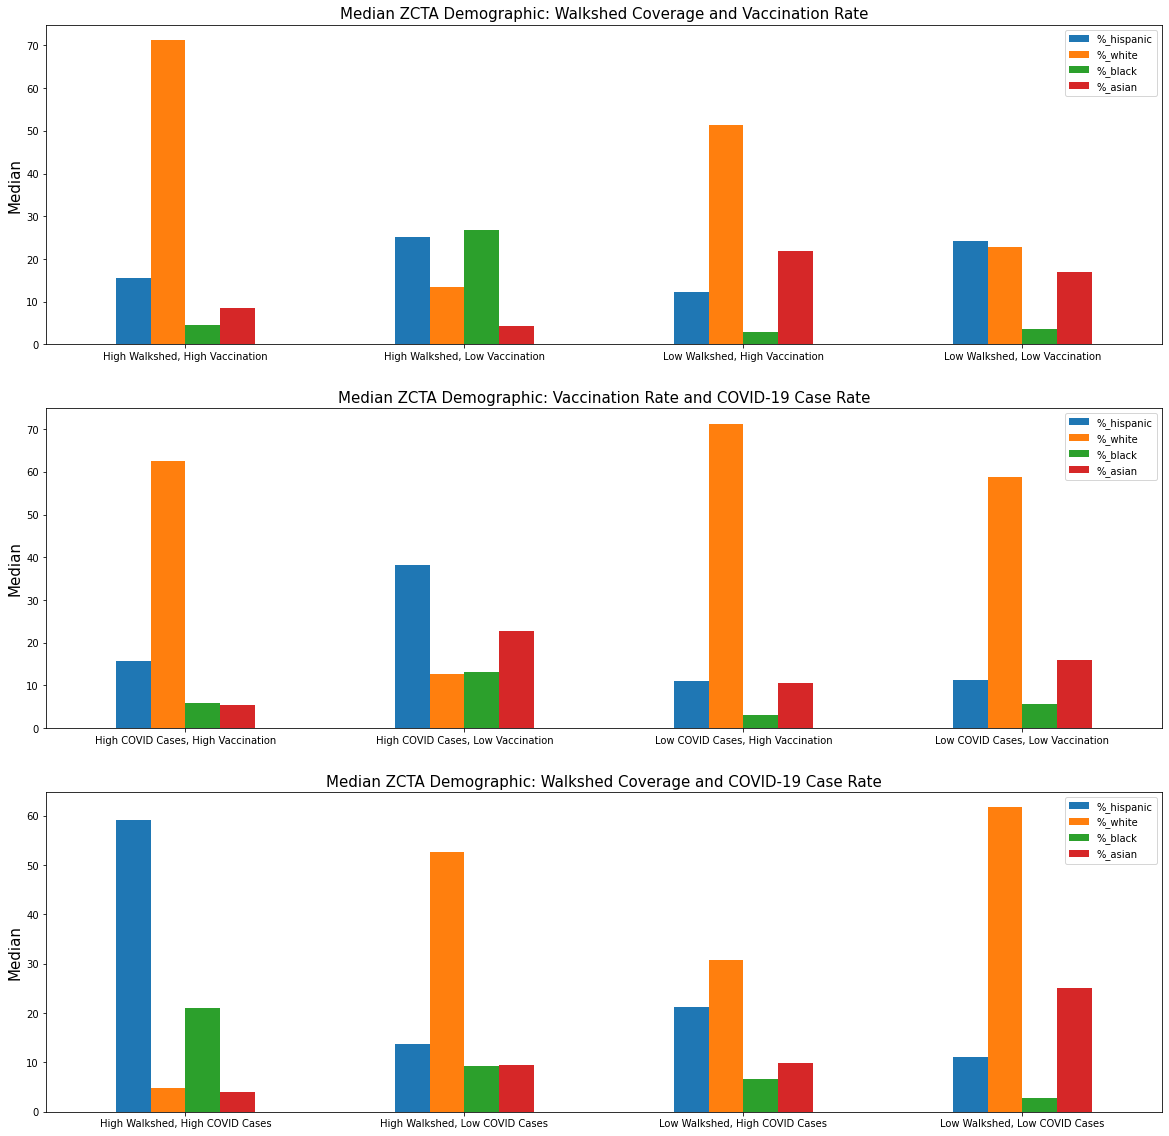

In [35]:
import numpy as np


fig, axs = plt.subplots(3,1, figsize=(20,20))

ax1, ax2, ax3 = axs
                        
median_quart_isovac.reset_index().plot( ax=ax1, 
    x="quartile_iso_vac", y=['%_hispanic',
 '%_white',
 '%_black',
 '%_asian'], kind="bar")
ax1.set_title("Median ZCTA Demographic: Walkshed Coverage and Vaccination Rate", fontsize=15)
ax1.set_ylabel("Median", fontsize=15)
ax1.set_xlabel("", fontsize=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
                        
median_quart_vaccases.reset_index().plot( ax=ax2, 
    x="quartile_vac_cases", y=['%_hispanic',
 '%_white',
 '%_black',
 '%_asian'], kind="bar")
ax2.set_title("Median ZCTA Demographic: Vaccination Rate and COVID-19 Case Rate", fontsize=15)
ax2.set_ylabel("Median", fontsize=15)
ax2.set_xlabel("", fontsize=15)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

median_quart_isocases.reset_index().plot(ax=ax3, 
    x="quartile_iso_cases", y=['%_hispanic',
 '%_white',
 '%_black',
 '%_asian'], kind="bar")
ax3.set_title("Median ZCTA Demographic: Walkshed Coverage and COVID-19 Case Rate", fontsize=15)
ax3.set_ylabel("Median", fontsize=15)
ax3.set_xlabel("", fontsize=15)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

This high/low analysis is really valuable. We can see spatially the mismatch between vaccine access and vaccination rates and then dive in further to the demographics. 

# Spatial Autocorrelation
In this section, we'll look at the spatial autocorrelation of vaccination rates in order to identify clustering. While interesting, this analysis is of less use to us because it doesn't correlate with other explanatory variables. I would like to know how to extract values from the Moran Local Scatterplot to know which zip codes are falling into the high/low categories.

## Global Autocorrelation

In [104]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
wq.transform = 'r'

In [105]:
# create a new column for the spatial lag
gdf['partial_lag'] = lps.weights.lag_spatial(wq, gdf['%_partial'])

In [106]:
# generate the Moran statistic
y = gdf['%_partial']
moran = Moran(y, wq)

print(moran.I)

0.21045296572095473


In [107]:
# calculate p-value
print(moran.p_sim)

0.001


## Local Autocorrelation

In [108]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

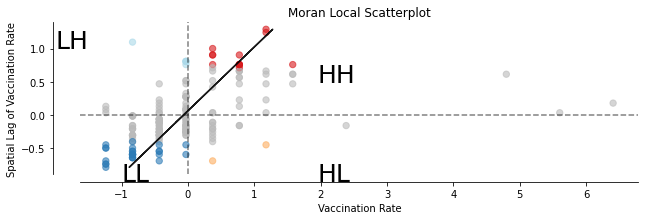

In [109]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)

ax.set_xlabel("Vaccination Rate")
ax.set_ylabel('Spatial Lag of Vaccination Rate')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

# Spatial Regression
The following workflow is taken from [Geographic Data Science for Python: Spatial Regression](https://geographicdata.science/book/notebooks/11_regression.html). Spatial regression doesn't seem to be the best analysis tool for our dataset -- I think it is better suited for point data with a larger number of observations. However, the results of the multivariate regression are interesting, and we could further refine the model in the future.

## Spatial Regression with COVID data

In [110]:
# store explanatory variable names in a list
variable_names = ['cases_100k', 'deaths_100k', '%_iso']

In [111]:
# non-spatial multivariate regression
m1 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names].values,
                name_y='%_partial', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :      6.0734                Number of Variables   :           4
S.D. dependent var  :      2.4932                Degrees of Freedom    :         173
R-squared           :      0.0595
Adjusted R-squared  :      0.0432
Sum squared residual:    1028.948                F-statistic           :      3.6483
Sigma-square        :       5.948                Prob(F-statistic)     :     0.01382
S.E. of regression  :       2.439                Log likelihood        :    -406.925
Sigma-square ML     :       5.813                Akaike info criterion :     821.850
S.E of regression ML:      2.4111                Schwarz criterion     :     834.554

-----------------------------------------------------------------------------

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


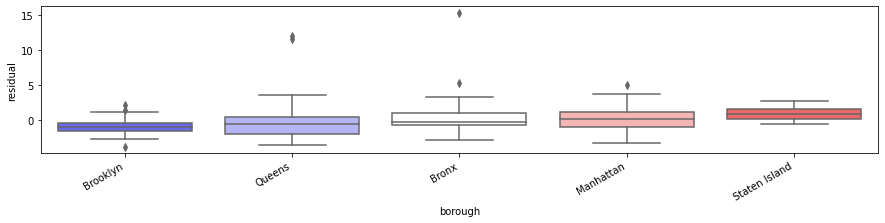

In [112]:
# make box plot of median residuals by neighborhood

gdf['residual'] = m1.u
medians = gdf.groupby("borough").residual.median().to_frame('borough_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('borough', 'residual', ax = ax,
                data=gdf.merge(medians, how='left',
                              left_on='borough',
                              right_index=True)
                   .sort_values('borough_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 51 disconnected components.
  warnings.warn(message)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


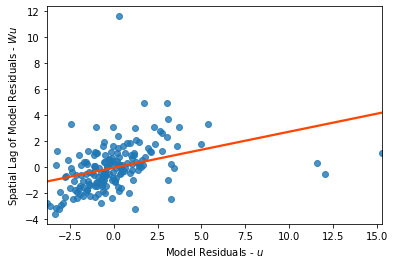

In [113]:
# calculate spatial weight and spatial lag and scatter plot

knn = weights.KNN.from_dataframe(gdf, k=1)

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(m1.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');



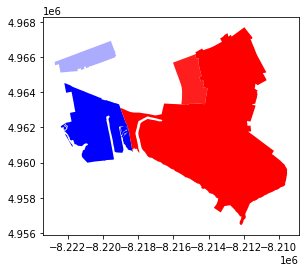

In [114]:
# do with more neighbors and plot

knn.reweight(k=4, inplace=True)
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
gdf.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .plot('local_I', cmap='bwr', marker='.');



## Spatial Regression with Race

In [115]:
#explonatory variable stored -- adding race into the analysis 
variable_names_2 = ['cases_100k', 'deaths_100k', '%_iso','%_hispanic', '%_black',
 '%_asian']

In [116]:
m2 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names_2].values,
                name_y='%_partial', name_x=variable_names_2)


print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :      6.0734                Number of Variables   :           7
S.D. dependent var  :      2.4932                Degrees of Freedom    :         170
R-squared           :      0.2577
Adjusted R-squared  :      0.2315
Sum squared residual:     812.090                F-statistic           :      9.8373
Sigma-square        :       4.777                Prob(F-statistic)     :   2.647e-09
S.E. of regression  :       2.186                Log likelihood        :    -385.978
Sigma-square ML     :       4.588                Akaike info criterion :     785.957
S.E of regression ML:      2.1420                Schwarz criterion     :     808.190

-----------------------------------------------------------------------------

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


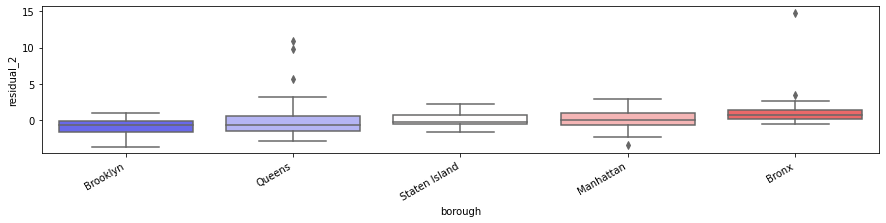

In [117]:
# make box plot of median residuals by neighborhood

gdf['residual_2'] = m2.u
medians = gdf.groupby("borough").residual_2.median().to_frame('borough_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('borough', 'residual_2', ax = ax,
                data=gdf.merge(medians, how='left',
                              left_on='borough',
                              right_index=True)
                   .sort_values('borough_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 51 disconnected components.
  warnings.warn(message)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


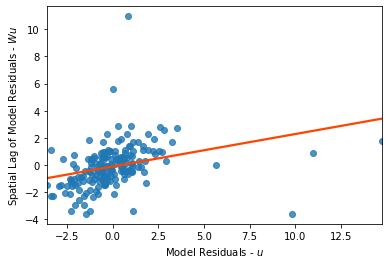

In [118]:
# calculate spatial weight and spatial lag and scatter plot

knn_2 = weights.KNN.from_dataframe(gdf, k=1)

lag_residual = weights.spatial_lag.lag_spatial(knn_2, m2.u)
ax = seaborn.regplot(m2.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');



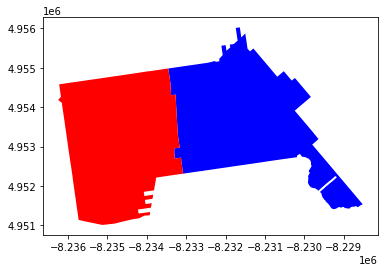

In [119]:
# do with more neighbors and plot

knn_2.reweight(k=4, inplace=True)
outliers = esda.moran.Moran_Local(m2.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
gdf.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .plot('local_I', cmap='bwr', marker='.');


## Spatial Regression with Other Demographic Data

In [120]:
# including people over 65, living in poverty, foreign born, no high school education
variable_names_3 = ['cases_100k', 'deaths_100k', '%_iso', '%_hispanic',
 '%_black',
 '%_asian',
 '%_over65',
 '%_poverty',
 '%_foreign',
 '%_lessHS']

In [57]:
m3 = spreg.OLS(gdf['%_partial'].values, gdf[variable_names_3].values,
                name_y='%_partial', name_x=variable_names_3)


print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   %_partial                Number of Observations:         177
Mean dependent var  :      6.0734                Number of Variables   :          11
S.D. dependent var  :      2.4932                Degrees of Freedom    :         166
R-squared           :      0.6018
Adjusted R-squared  :      0.5778
Sum squared residual:     435.654                F-statistic           :     25.0871
Sigma-square        :       2.624                Prob(F-statistic)     :   1.941e-28
S.E. of regression  :       1.620                Log likelihood        :    -330.864
Sigma-square ML     :       2.461                Akaike info criterion :     683.728
S.E of regression ML:      1.5689                Schwarz criterion     :     718.666

-----------------------------------------------------------------------------

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


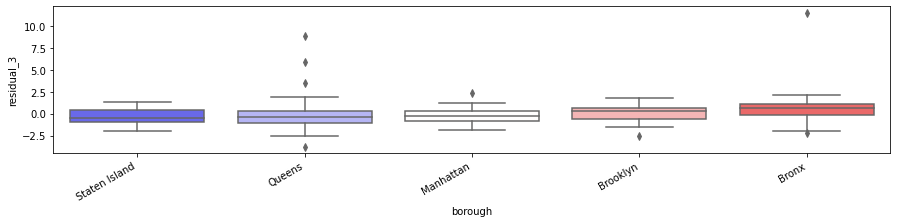

In [121]:
# make box plot of median residuals by neighborhood

gdf['residual_3'] = m3.u
medians = gdf.groupby("borough").residual_3.median().to_frame('borough_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('borough', 'residual_3', ax = ax,
                data=gdf.merge(medians, how='left',
                              left_on='borough',
                              right_index=True)
                   .sort_values('borough_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 51 disconnected components.
  warnings.warn(message)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


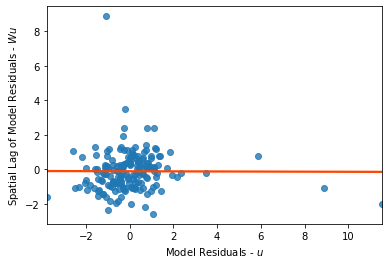

In [122]:
# calculate spatial weight and spatial lag and scatter plot

knn_3 = weights.KNN.from_dataframe(gdf, k=1)

lag_residual = weights.spatial_lag.lag_spatial(knn_3, m3.u)
ax = seaborn.regplot(m3.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');



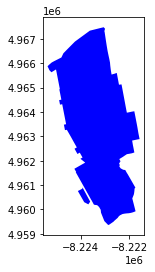

In [123]:
# do with more neighbors and plot

knn_3.reweight(k=4, inplace=True)
outliers = esda.moran.Moran_Local(m3.u, knn_3, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
gdf.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .plot('local_I', cmap='bwr', marker='.');



# Clustering and Regionalization
This workflow is from [Geographic Data Science with Python: Clustering and Regionalization.](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html) This analysis looks far more promising and works better with our dataset. Since we have so many different variables, this is a good way to visualize all of them and figure out which ones are most relevant to our analysis. 

In [124]:
# choose variables for clustering effects
cluster_variables =  ['%_partial', '%_fully', 'cases_100k', 'deaths_100k', '%_iso', '%_hispanic',
 '%_black',
 '%_asian',
 '%_over65',
 '%_poverty',
 '%_foreign',
 '%_lessHS']

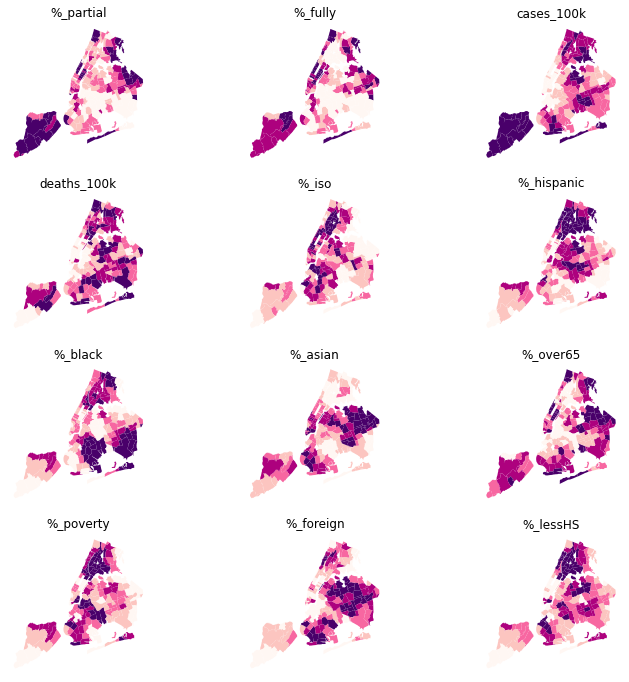

In [125]:
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='RdPu')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [126]:
# check for islands
w = Queen.from_dataframe(gdf)
w.islands
# It's Roosevelt Island

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 37.
  warnings.warn(message)


[37]

In [127]:
# conduct spatial autocorrelation on all variables


# Set seed for reproducibility
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(gdf[variable], w) for variable in cluster_variables]
# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(cluster_variables, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

('WARNING: ', 37, ' is an island (no neighbors)')


,Moran's I,P-value
Variable,,
%_partial,0.332806,0.001
%_fully,0.416504,0.001
cases_100k,0.752440,0.001
deaths_100k,0.453602,0.001
%_iso,0.467265,0.001
%_hispanic,0.762077,0.001
%_black,0.723834,0.001
%_asian,0.670211,0.001
%_over65,0.481616,0.001


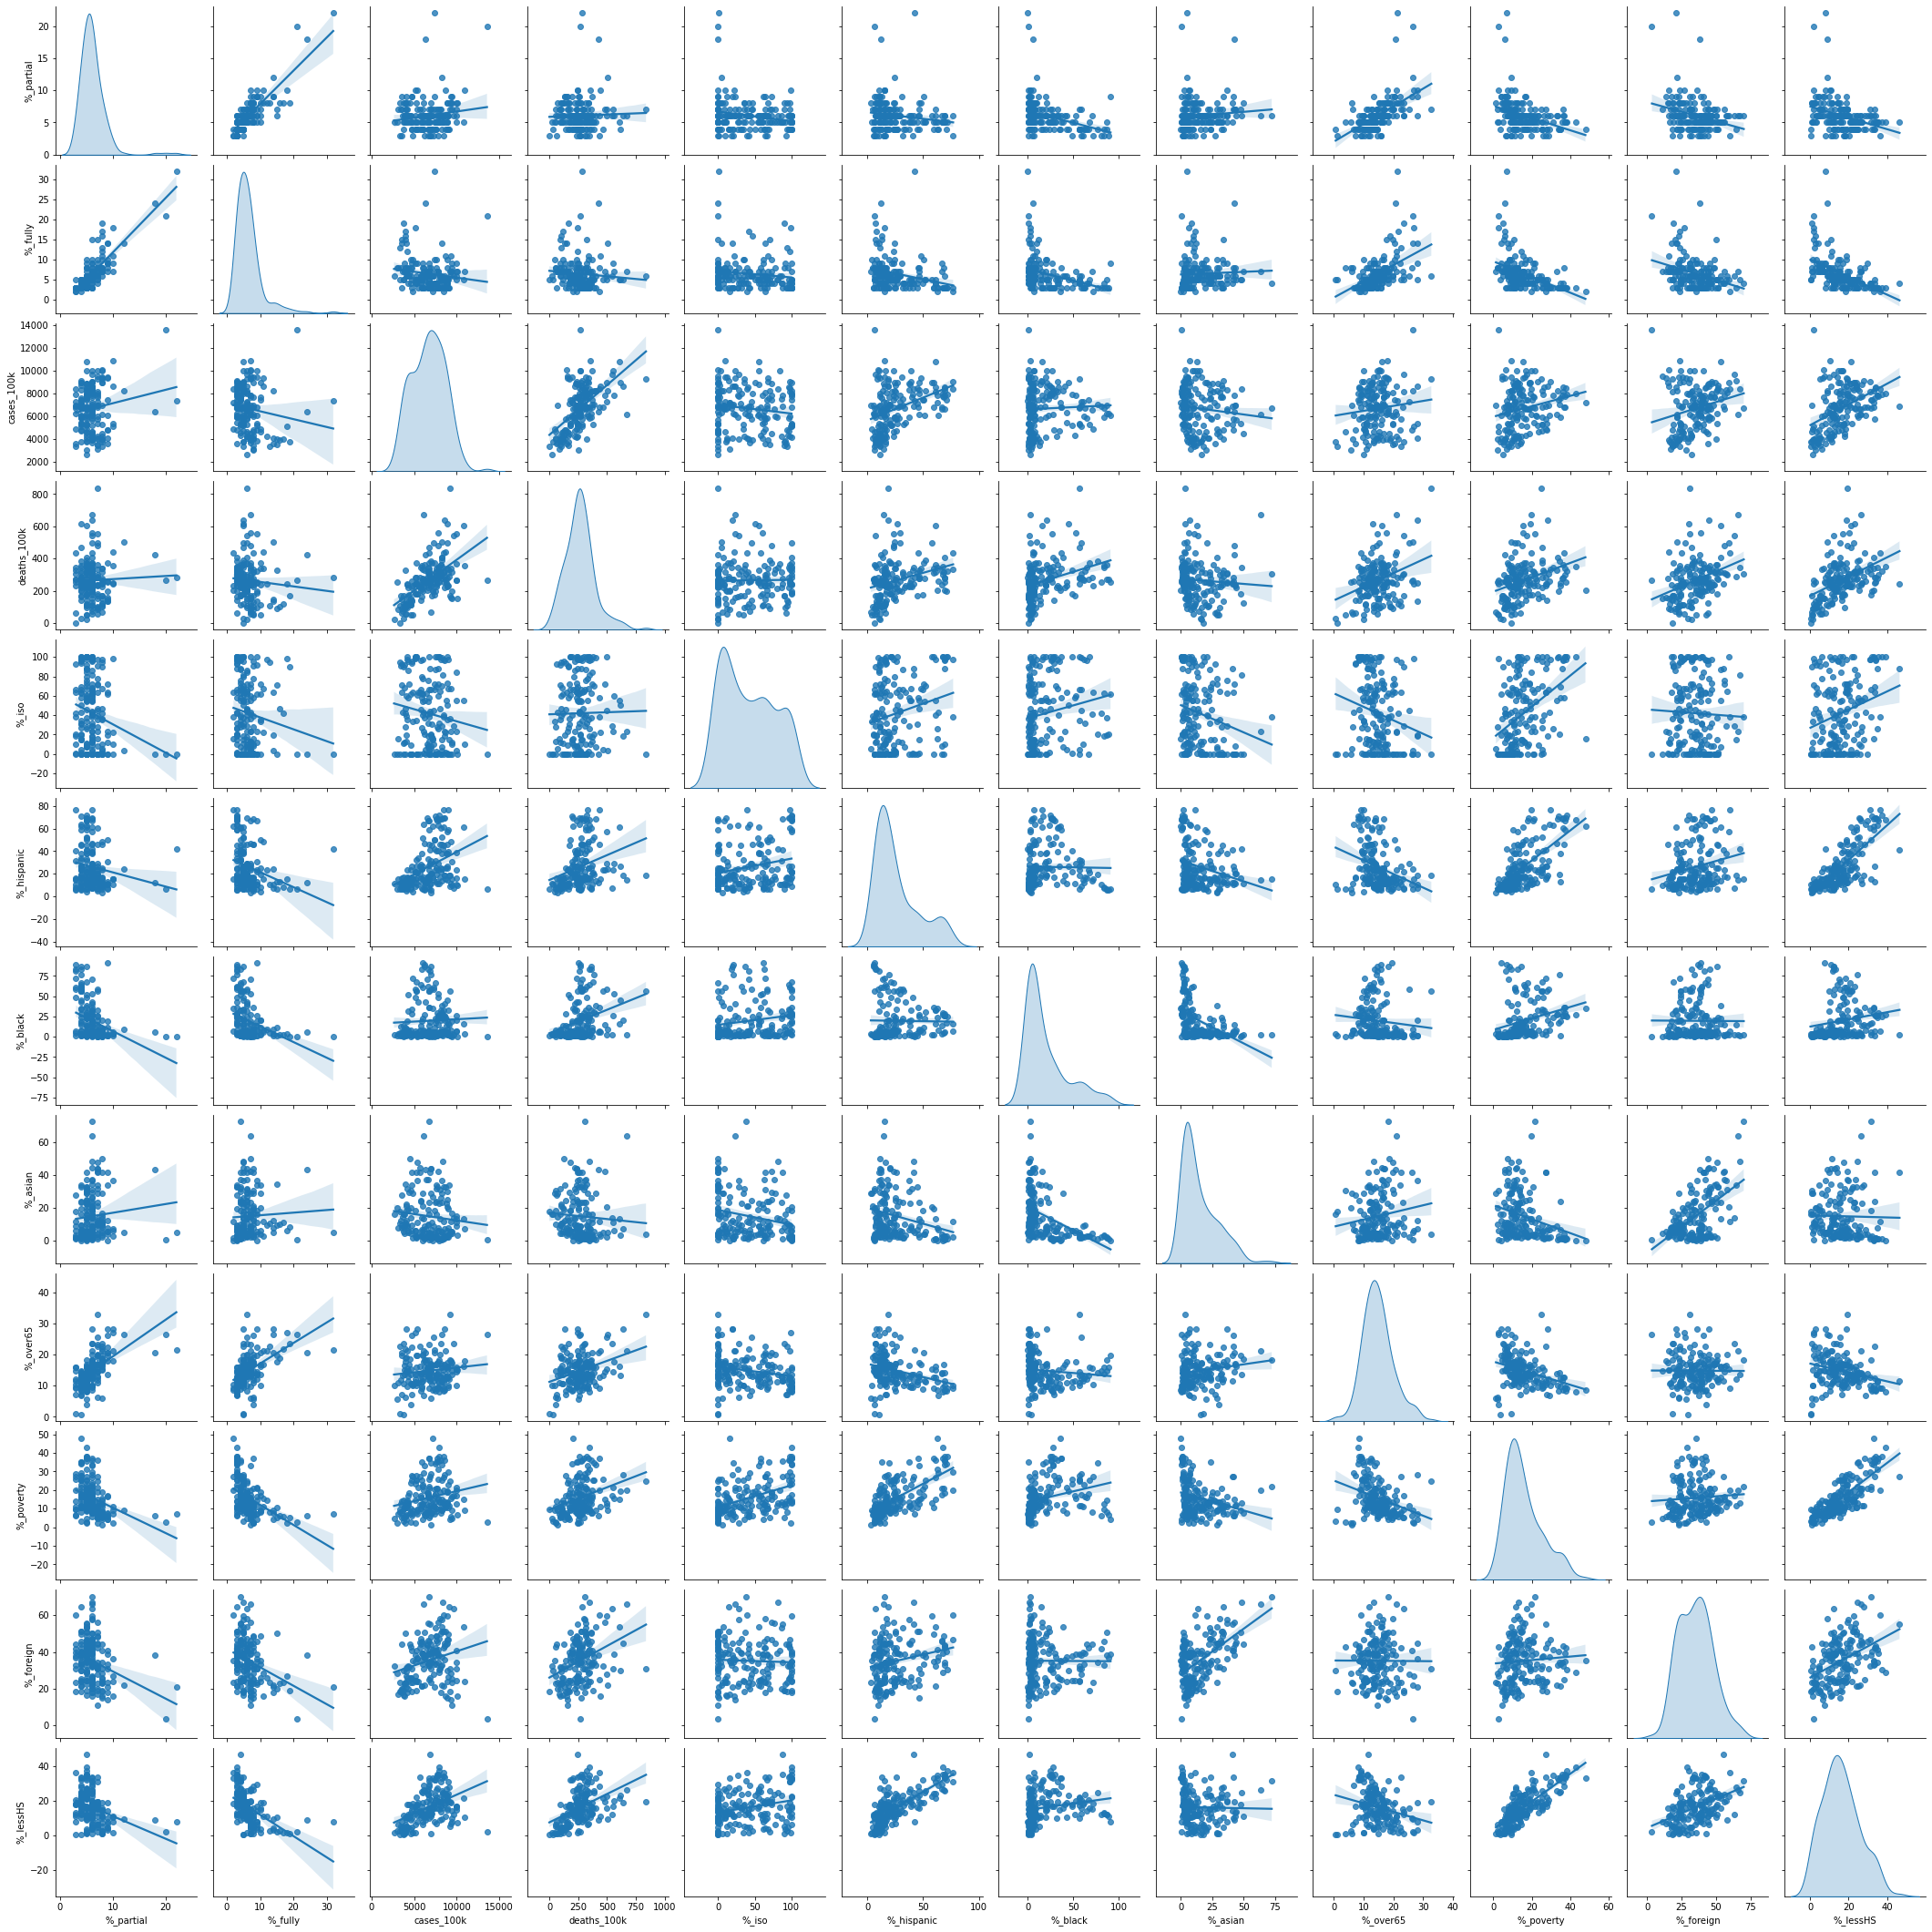

In [128]:
# create scatterplots of each combo of variables
# the diagonal shows density plot for each variable

_ = seaborn.pairplot(gdf[cluster_variables], kind='reg', diag_kind='kde')


We are most interested in the scatterplots of between vaccination rates and other explantory variables. So the first two columns are of most interest to us, to identify which variables correlate strongly with vaccination rates. 

## K-Means Clustering

This method clusters observations by means. I chose k=5, but that could be changed.

In [129]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

In [130]:
# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(gdf[cluster_variables])

In [131]:
k5cls.labels_

array([0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 4, 4, 4, 2, 2, 2, 2, 4, 4, 0, 4, 2, 0, 0, 0, 4, 0, 0, 0,
       1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 4, 4, 2, 4, 4, 4, 4,
       0, 0, 4, 2, 0, 4, 2, 1, 4, 2, 4, 2, 4, 2, 0, 0, 0, 2, 2, 2, 4, 0,
       1, 1, 4, 4, 2, 1, 3, 0, 2, 0, 4, 3, 4, 4, 0, 1, 4, 2, 2, 2, 4, 4,
       4, 0, 0, 0, 4, 2, 2, 1, 3, 1, 1, 1, 1, 4, 1, 2, 2, 2, 4, 2, 4, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
       3], dtype=int32)

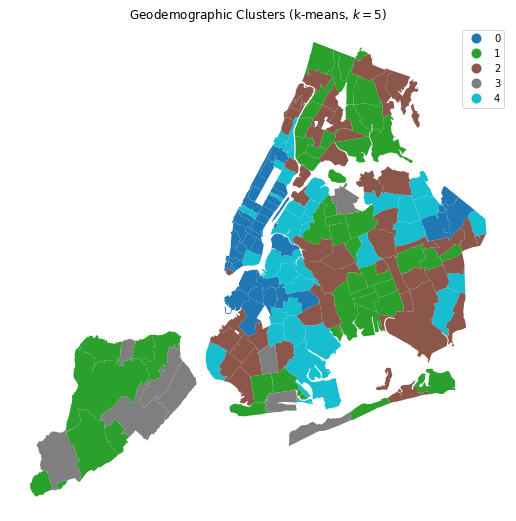

In [132]:
# Plot the clustering

# Assign labels into a column
gdf['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=5$)')
# Display the map
plt.show()

These clusters are kind of disjointed and might not be the most descriptive.

In [133]:
# Group data table by cluster label and count observations
k5sizes = gdf.groupby('k5cls').size()
k5sizes

k5cls
0    42
1    45
2    47
3     9
4    34
dtype: int64

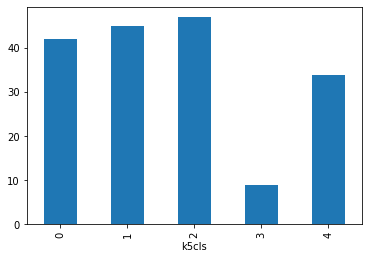

In [134]:
# bar graph of the clusters
_ = k5sizes.plot.bar()

In [135]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
gdf ['zarea'] = gdf.area
areas = gdf.dissolve(by='k5cls', aggfunc='sum')['zarea']
areas

k5cls
0    1.340619e+08
1    4.393068e+08
2    3.643561e+08
3    1.437457e+08
4    2.368072e+08
Name: zarea, dtype: float64

In [136]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = gdf.groupby('k5cls')[cluster_variables].mean()
k5means.T.round(3)

k5cls,0,1,2,3,4
%_partial,6.143,6.133,5.574,8.333,6.000
%_fully,8.357,5.467,5.681,8.111,6.235
cases_100k,4034.614,8577.949,7074.020,10535.403,5736.334
deaths_100k,130.380,344.024,284.311,374.319,269.394
%_iso,45.089,41.319,35.187,28.774,52.073
%_hispanic,11.845,37.340,32.371,21.034,21.780
%_black,9.413,18.210,25.286,9.211,29.471
%_asian,16.507,13.881,14.617,9.560,16.123
%_over65,14.168,15.066,14.186,17.234,15.304
%_poverty,10.526,18.060,18.336,13.504,16.309


In [137]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = gdf.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
             count         mean         std          min          25%  \
%_partial     42.0     6.142857    1.661199     3.000000     5.000000   
%_fully       42.0     8.357143    4.029292     2.000000     6.000000   
cases_100k    42.0  4034.613571  532.375821  2632.080000  3711.010000   
deaths_100k   42.0   130.380000   71.535369     0.000000    91.152500   
%_iso         42.0    45.088780   37.041166     0.000000     9.639295   
%_hispanic    42.0    11.845480    5.023017     3.784498     7.752603   
%_black       42.0     9.412960   14.493178     0.284553     2.378659   
%_asian       42.0    16.507171   10.989849     1.873135     8.601566   
%_over65      42.0    14.168091    6.346212     0.679172    10.461671   
%_poverty     42.0    10.525667    6.388013     2.157399     6.014598   
%_foreign     42.0    26.591640    8.379010    15.989982    20.125471   
%_lessHS      42.0     6.817223    5.258206     0.232594     2.605589   

                     50%   

In [138]:
# Index db on cluster ID
tidy_gdf = gdf.set_index('k5cls')
# Keep only variables used for clustering
tidy_gdf = tidy_gdf[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_gdf = tidy_gdf.stack()
# Take indices into proper columns
tidy_gdf = tidy_gdf.reset_index()
# Rename column names
tidy_gdf = tidy_gdf.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_gdf.head()

,k5cls,Attribute,Values
0,0,%_partial,5.000000
1,0,%_fully,6.000000
2,0,cases_100k,4081.400000
3,0,deaths_100k,105.020000
4,0,%_iso,59.831398


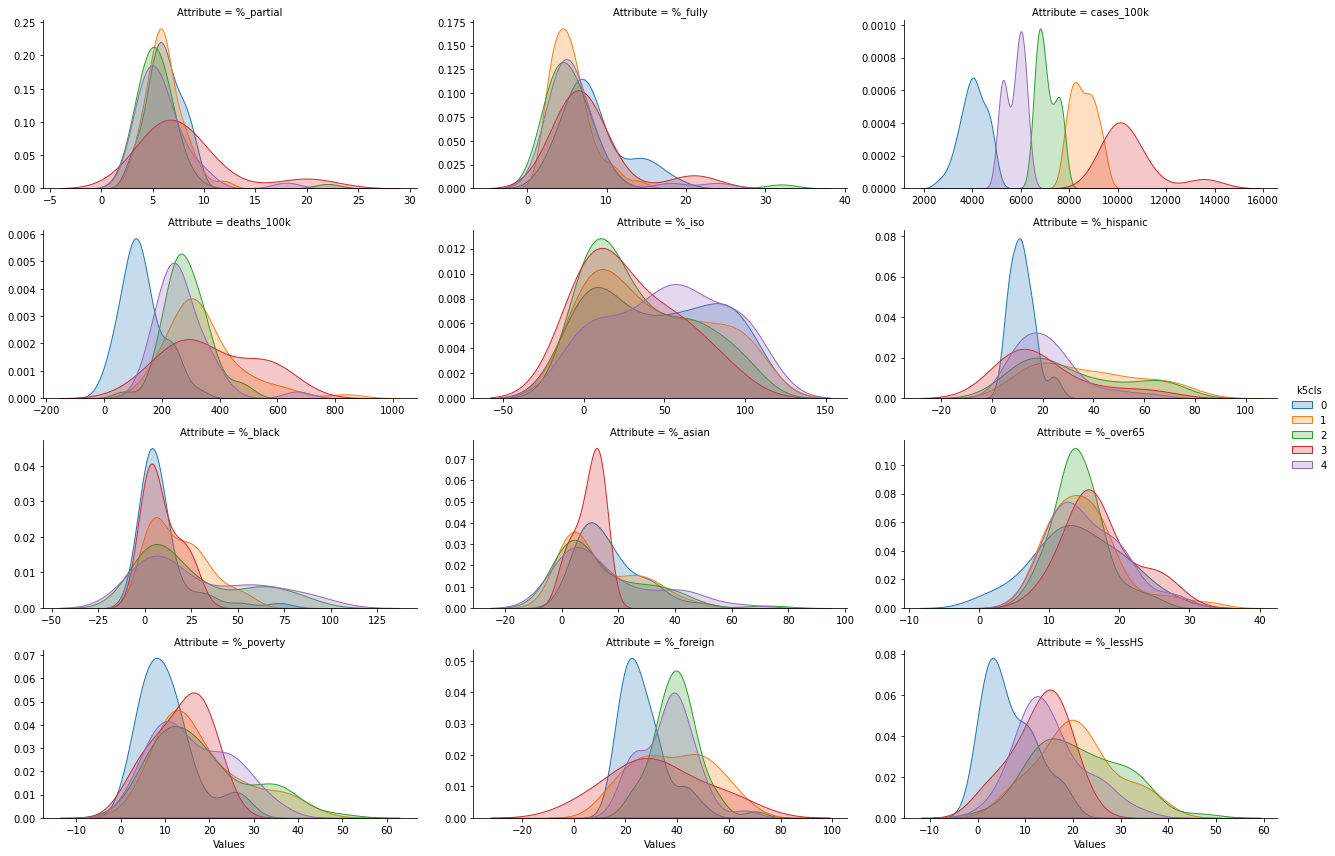

In [139]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_gdf, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

This is a useful way of looking at the distribution of each variable by cluster. This can help us better understand how our variables are spatially distributed. 

## Hierarchical Clustering
This is a different method that uses agglomerative hierarchical clustering. Let's see how the results vary from k-means.

In [140]:
# Set seed for reproducibility
numpy.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(gdf[cluster_variables])
# Assign labels to main data table
gdf['ward5'] =model.labels_

In [141]:
# check size of clusters
ward5sizes = gdf.groupby('ward5').size()
ward5sizes

ward5
0    30
1    34
2    42
3    40
4    31
dtype: int64

In [142]:
# check simple averages of clusters
ward5means = gdf.groupby('ward5')[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
%_partial,7.067,6.000,6.143,6.050,5.129
%_fully,6.700,6.235,8.357,5.675,5.097
cases_100k,9477.742,5736.334,4034.614,7938.201,6820.807
deaths_100k,349.877,269.394,130.380,324.970,281.208
%_iso,31.449,52.073,45.089,46.452,31.308
%_hispanic,27.691,21.780,11.845,42.808,27.353
%_black,12.930,29.471,9.413,20.273,28.774
%_asian,11.845,16.123,16.507,14.128,15.394
%_over65,16.518,15.304,14.168,14.252,14.007
%_poverty,14.470,16.309,10.526,20.750,17.160


In [143]:
# Index db on cluster ID
tidy_gdf = gdf.set_index('ward5')
# Keep only variables used for clustering
tidy_gdf = tidy_gdf[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_gdf = tidy_gdf.stack()
# Take indices into proper columns
tidy_gdf = tidy_gdf.reset_index()
# Rename column names
tidy_gdf = tidy_gdf.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_gdf.head()

,ward5,Attribute,Values
0,2,%_partial,5.000000
1,2,%_fully,6.000000
2,2,cases_100k,4081.400000
3,2,deaths_100k,105.020000
4,2,%_iso,59.831398


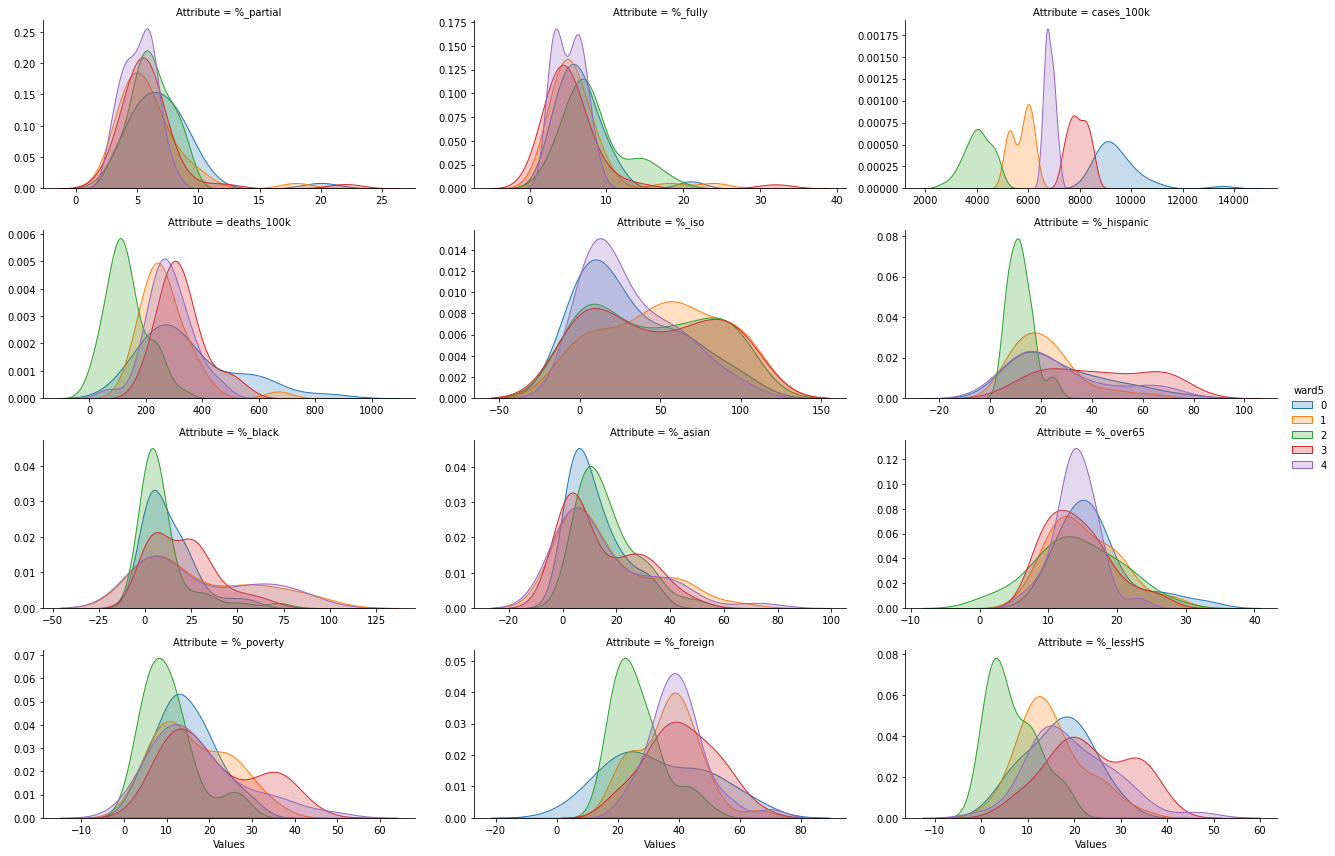

In [144]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_gdf, col='Attribute', hue='ward5', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

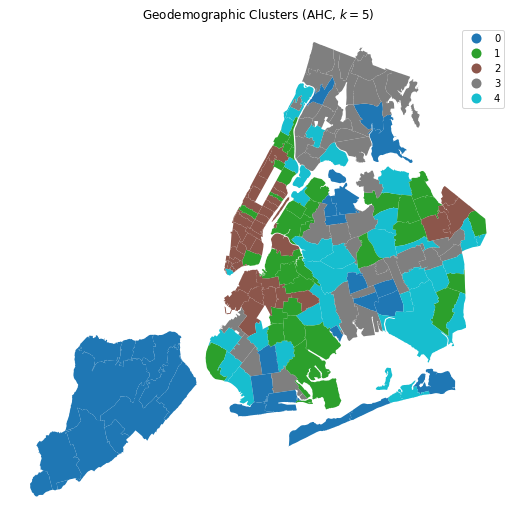

In [145]:
gdf['ward5'] =model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='ward5', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Clusters (AHC, $k=5$)')
# Display the map
plt.show()

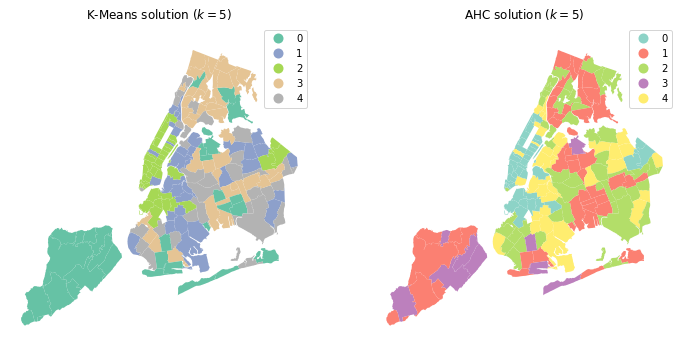

In [146]:
# Display k-means and hierarchical clustering side by side

gdf['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='ward5', categorical=True, cmap='Set2', 
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('K-Means solution ($k=5$)')

ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='k5cls', categorical=True, cmap='Set3',
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

## Spatially Constrained Hierarchical Clustering
This constrains the agglomeration to only fully connected clusters in order to adhere to Tobler's Law (things are more related to closer things). 

In [147]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(gdf[cluster_variables])

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(connectivity=<177x177 sparse matrix of type '<class 'numpy.float64'>'
	with 784 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

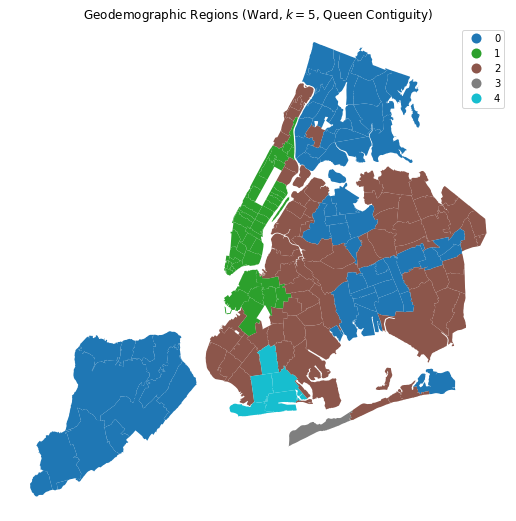

In [148]:
gdf['ward5wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='ward5wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=5$, Queen Contiguity)')
# Display the map
plt.show()

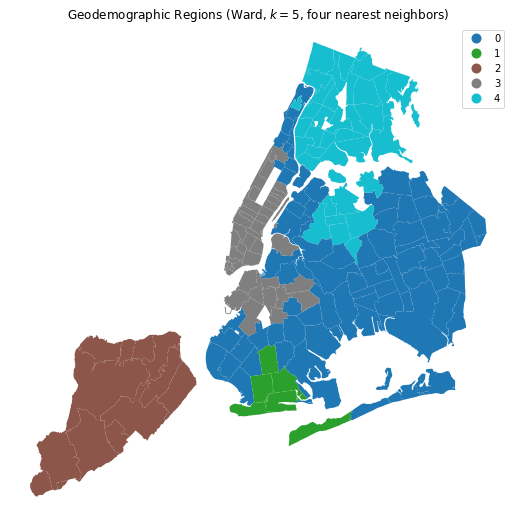

In [149]:
# use KNN as spatial constraint
w = KNN.from_dataframe(gdf, k=4)

numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(gdf[cluster_variables])

gdf['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Regions (Ward, $k=5$, four nearest neighbors)')
# Display the map
plt.show()

Spatially restricting the clusters provides completely different results. This might be the best method of analysis, given the clustering of demographics in different NYC neighborhoods. <br>

We will choose between these different clustering methods to see which one best reveals underlying patterns in the data.

# Conclusion
We have a LOT of results here, some good, some bad. This gives us a lot of options to further refine our spatial analysis and figure out what the most meaningful data is to our project. 